In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
import copy
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
np.random.seed(42)
random.seed(42)
RANDOM_SEED = 42
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('data.csv')
data = data[data.Datetime < '2020-12-08']
data.head()

,Datetime,temp,templow,icon,baro,hum,rain,fog,thunder,snow,...,desc_No weather data available,desc_Overcast.,desc_Partly cloudy.,desc_Partly sunny.,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sunny.,desc_Thunderstorms. Fog.,confinement
0,2014-01-01 00:00:00,7.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01 04:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [665]:
drop = ['etat_barre_ce', 'etat_barre_lc', 'templow', 'baro', 'etat_barre_pv', 'Année', 'Mois', 'Jour', 'Heure', 'Jour semaine']
target_ce = ['q_ce', 'k_ce']
target_lc = ['q_lc', 'k_lc']
target_pv = ['q_pv', 'k_pv']
all_ = drop + target_ce + target_lc + target_pv
features = [x for x in data.columns.tolist() if x not in all_]
df = copy.deepcopy(data)
df = df.drop(drop, axis=1)
df_ce = copy.deepcopy(df[features + target_ce])
df_lc = copy.deepcopy(df[features + target_lc])
df_pv = copy.deepcopy(df[features + target_pv])

In [467]:
def rolling_custom_q(d):
    try:
        return df_pv.loc[d - 168, 'q_pv']
    except KeyError:
        return float('nan')
s_q = pd.Series([rolling_custom_q(d) for d in df_pv.index])
def rolling_custom_k(d):
    try:
        return df_pv.loc[d - 168, 'k_pv']
    except KeyError:
        return float('nan')
s_k = pd.Series([rolling_custom_k(d) for d in df_pv.index])

In [613]:
def rolling_custom(d, df, label):
    try:
        return df.loc[d - 168, label]
    except KeyError:
        return float('nan')

In [690]:
df_pv['back_q'] = pd.Series([rolling_custom(d, df_pv, 'q_pv') for d in df_pv.index])
df_pv['back_k'] = pd.Series([rolling_custom(d, df_pv, 'k_pv') for d in df_pv.index])

In [691]:
df_pv

,Datetime,temp,icon,hum,rain,fog,thunder,snow,Férié,Vacances,...,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sunny.,desc_Thunderstorms. Fog.,confinement,q_pv,k_pv,back_q,back_k
0,2014-01-01 00:00:00,7.0,17.0,92.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,6.0,17.0,92.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,486.0,6.17889,NaN,NaN
2,2014-01-01 02:00:00,6.0,17.0,92.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,571.0,6.66222,NaN,NaN
3,2014-01-01 03:00:00,6.0,17.0,92.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,532.0,5.56611,NaN,NaN
4,2014-01-01 04:00:00,6.0,17.0,92.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,458.0,4.63444,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60787,2020-12-07 19:00:00,24.0,2.0,37.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,647.0,8.07000,557.0,6.50611
60788,2020-12-07 20:00:00,24.0,2.0,37.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,599.0,6.75222,491.0,5.60889
60789,2020-12-07 21:00:00,23.0,2.0,37.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,570.0,6.46167,493.0,4.76945
60790,2020-12-07 22:00:00,21.5,2.0,37.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,398.0,4.32445,356.0,3.50445


In [510]:
df[df.Datetime < '2017-01-01']

,Datetime,temp,templow,icon,baro,hum,rain,fog,thunder,snow,...,desc_No weather data available,desc_Overcast.,desc_Partly cloudy.,desc_Partly sunny.,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sunny.,desc_Thunderstorms. Fog.,confinement
0,2014-01-01 00:00:00,7.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01 04:00:00,6.0,6.0,17.0,1011.0,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2016-12-31 19:00:00,-4.0,-4.0,14.0,1030.0,98.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26300,2016-12-31 20:00:00,-4.0,-4.0,14.0,1030.0,98.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26301,2016-12-31 21:00:00,-4.0,-4.0,14.0,1030.0,98.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26302,2016-12-31 22:00:00,-4.0,-4.0,14.0,1030.0,98.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Utils

In [5]:
def create_train_test(df, date_min, date_max, label, prefix, start, dropna=True):
    if dropna:
        drop = df[label + '_' + prefix].notnull()
        train, test = df[(df.Datetime <= date_min) & drop & (df.Datetime >= start)], df[(df.Datetime > date_min) & (df.Datetime <= date_max) & drop]
    x_train, y_train = train.drop(['Datetime', 'q_' + prefix, 'k_' + prefix], axis=1), train[label + '_' + prefix]
    x_test, y_test = test.drop(['Datetime', 'q_' + prefix, 'k_' + prefix], axis=1), test[label + '_' + prefix]
    return x_train, y_train, x_test, y_test

In [169]:
def train(models, X_train, y_train, X_test, y_test):
    model_trained = []
    for model in models:
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=40, 
                  verbose=False)
                 
        model_trained.append(model)
    return model_trained

def evaluate(models, X_test, y_test):
    rmse = []
    for model in models:
        rmse.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    return rmse

<AxesSubplot:>

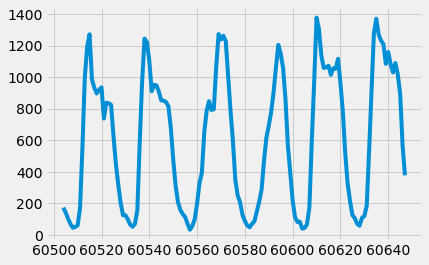

In [7]:
df[(df.Datetime >= '2020-11-26') & (df.Datetime < '2020-12-02')].q_ce.plot()

q

CE : 95/123 à partir du mois de mai 2020 (sans k & q past week)
LC : 53 à partir du mois de janvier 2020 ( only with q past week)
SP : 50 a partir du mois de janvier 2020 (only with q past week)

k

CE : 3.75 septembre 2020 (mais pas bon sur l'avant derniere semaine sans k & q past week) 
LC : 3  janvier 2020 (avec k pas week)
SP : 1.26 juin 2019 (++) (avec k & q past week)

In [504]:
24*6

144

# Champs elysées

In [713]:
#dates = 
X_train, y_train, X_test, y_test = create_train_test(df_pv, '2020-12-02', '2020-12-08', 'k', 'pv', '2019-06-01')
models = [ LGBMRegressor(n_estimators=300, colsample_bytree=0.8, subsample=0.8, learning_rate=0.1),
         XGBRegressor(n_estimators=300, max_depth=6, min_child_weight=5, subsample=0.6, random_state=27), CatBoostRegressor(verbose=False)]
trained = train(models, X_train, y_train, X_test, y_test)
rmses = evaluate(trained, X_test, y_test.values)
rmses

[1.4000253806493923, 1.4317635285058194, 1.5292474156654738]

In [716]:
np.sqrt(mean_squared_error((y_pred+y_pred2)/2, y_test.values))

1.359427685781715

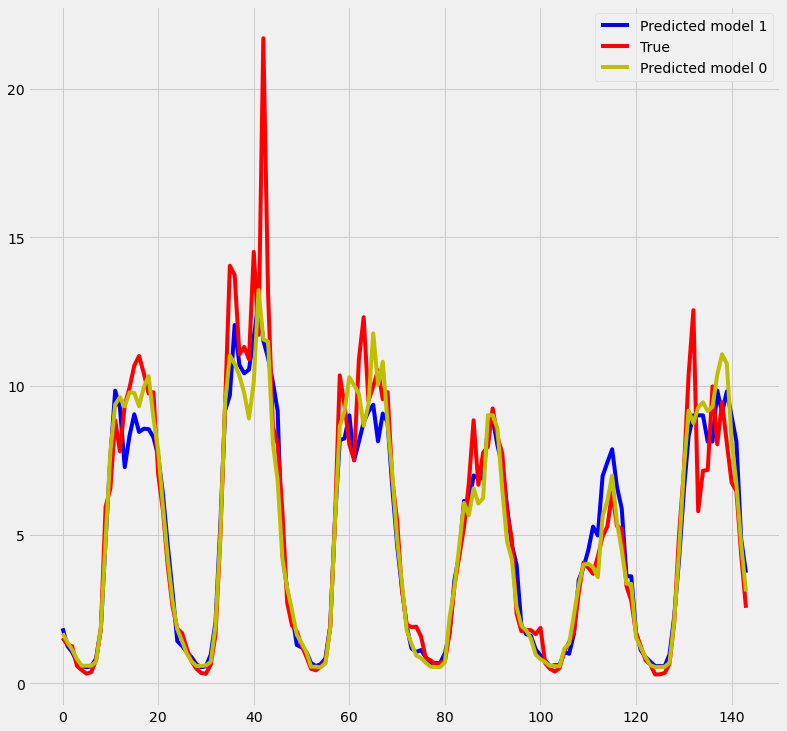

In [715]:
y_pred = trained[1].predict(X_test)
y_pred2 = trained[0].predict(X_test)
plt.figure(figsize=(12,12))
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted model 1", color='b')
plt.plot(np.arange(len(y_pred)), y_test.values, label="True", color='r')
plt.plot(np.arange(len(y_pred)), y_pred2, label="Predicted model 0", color='y')
plt.legend()
plt.show()

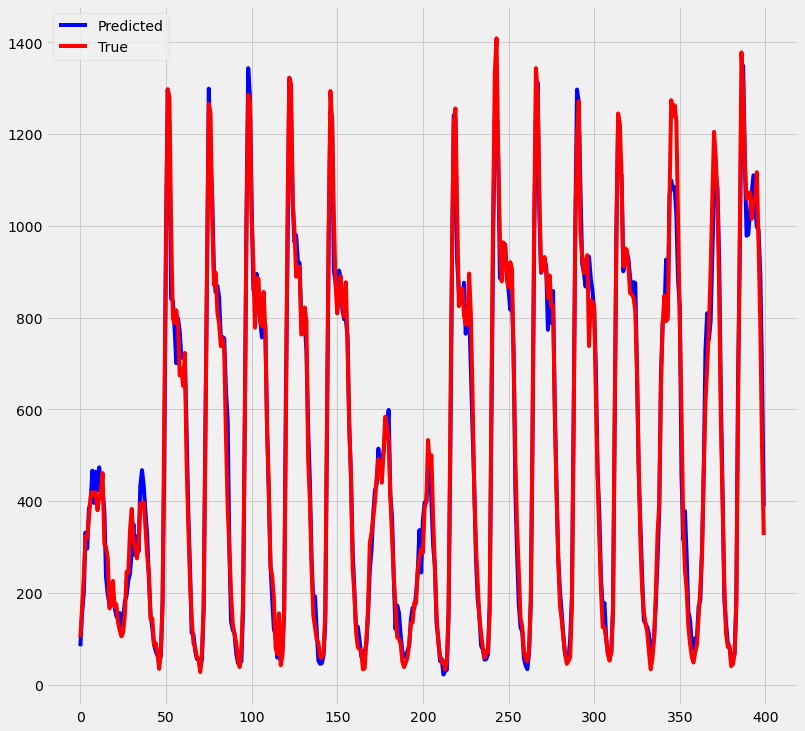

In [94]:
from pycaret.regression import *

In [130]:
(31+31)*24/144

10.333333333333334

In [131]:
drop = df_ce['q_ce'].notnull()
exp_reg = setup(df_ce[(df_ce.Datetime>='2020-10-01') & (df_ce.Datetime < '2020-12-02') & drop].drop(['Datetime', 'k_ce'], axis=1), target='q_ce', 
                fold_strategy='timeseries', session_id = 123, silent=True)

,Description,Value
0,session_id,123
1,Target,q_ce
2,Original Data,"(1476, 118)"
3,Missing Values,True
4,Numeric Features,35
5,Categorical Features,82
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1033, 117)"


In [132]:
compare_models(['et', 'catboost', 'xgboost', 'lightgbm', 'rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,80.9621,15569.3943,120.3999,0.9181,0.3637,0.3084,1.2930
et,Extra Trees Regressor,77.9615,15537.1265,120.5463,0.9178,0.3294,0.2924,0.4990
lightgbm,Light Gradient Boosting Machine,87.7846,18236.2199,131.2637,0.9037,0.3948,0.3309,0.0250
xgboost,Extreme Gradient Boosting,91.5776,21831.8867,142.5033,0.8851,0.3796,0.3396,0.2050
rf,Random Forest Regressor,92.4599,22139.8061,144.9876,0.8831,0.3995,0.3724,0.1440


In [133]:
# Take the 3 bests models
catb = create_model('catboost', verbose=False)
et = create_model('et', verbose=False)
#lgbm = create_model('lightgbm', verbose=False)

In [134]:
# Blend all the 4 bests models
blend_all = blend_models(estimator_list = [catb, et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,134.1755,33191.8667,182.1864,0.8381,0.5528,0.6006
1,96.9073,26781.9103,163.6518,0.8578,0.5182,0.6589
2,87.6471,17920.1012,133.8660,0.9133,0.2764,0.1918
3,73.9865,12133.9221,110.1541,0.9362,0.2993,0.2289
4,69.9859,9636.8201,98.1673,0.9483,0.2342,0.1779
5,60.1894,9768.9360,98.8379,0.9426,0.2903,0.2163
6,65.2187,11846.2160,108.8403,0.9318,0.3084,0.2135
7,59.5893,8437.6071,91.8564,0.9590,0.3112,0.2519
8,61.0311,7810.3133,88.3760,0.9613,0.2586,0.1914
9,53.7643,7355.7278,85.7655,0.9478,0.2209,0.1487


In [114]:
# Finalise models and make predictions
final_blender = finalize_model(blend_all)
predictions = predict_model(final_blender, data = df_ce[(df_ce.Datetime > '2020-12-01') & (df_ce.Datetime <= '2020-12-07')].drop(['Datetime', 'k_ce'], axis=1))

In [135]:
predictions

,temp,templow,icon,baro,hum,rain,fog,thunder,snow,Férié,...,desc_Partly sunny.,desc_Passing clouds.,desc_Rain. Fog.,desc_Scattered clouds.,desc_Sunny.,desc_Thunderstorms. Fog.,confinement,q_ce,rolling,Label
60624,3.0,3.0,17.0,1027.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,216.0,220.0,251.882324
60625,3.0,3.0,17.0,1027.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,126.0,143.0,135.777014
60626,3.0,3.0,17.0,1027.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,106.0,111.0,115.716729
60627,3.0,3.0,17.0,1027.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,70.0,80.0,88.037556
60628,4.0,3.0,17.0,1027.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,58.0,58.0,60.187621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60763,19.5,15.0,6.0,1004.0,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1355.0,1149.0,981.945282
60764,19.5,15.0,6.0,1004.0,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1313.0,1058.0,925.819692
60765,18.5,15.0,6.0,1004.0,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,992.0,859.0,878.597452
60766,16.5,15.0,6.0,1004.0,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,769.0,568.0,671.799791
